## **3η εργαστηριακή άσκηση** | Link prediction


In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import statistics
from tabulate import tabulate
!pip install -U scipy==1.8.1
import scipy
import pandas as pd
from tqdm import tqdm
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
import os
os.chdir("/content/gdrive/MyDrive/ECE-COURSES/9-Κοινωνικά Δίκτυα/LAB-3_Data/")
!ls

meta.dbpedia-similar  out.dbpedia-similar  README.dbpedia-similar


In [6]:
table_view = lambda data: tabulate(data, tablefmt="grid")

## 1.Κατασκευή γράφου και προεργασία για την πρόβλεψη συνδέσμων

### 1.1 Create BDpedia graph
Χρησιμοποιήστε το dataset <a href="http://konect.cc/networks/dbpedia-similar/"> Similarities (DBpedia)</a>, για να κατασκευάσετε τον μη κατευθυνόμενο (undirected) γράφο $G$ <a href="https://dl.acm.org/doi/10.1145/2487788.2488173">[1]</a>,<a href="https://link.springer.com/chapter/10.1007/978-3-540-76298-0_52">[2]</a>. Οι κόμβοι του γράφου αναπαριστούν σελίδες της Wikipedia και οι ακμές σχέση ομοιότητας μεταξύ τους. Στην σελίδα <a href="http://konect.cc/networks/dbpedia-similar/"> KONECT (DBpedia)</a> μπορείτε να βρείτε πληροφορίες για τις ιδιότητες του γράφου.

In [7]:
# Read DBpedia dataset
# (MultiGraph allows parallel edges)
dbpedia = nx.read_edgelist("out.dbpedia-similar", create_using=nx.MultiGraph(), comments="%", nodetype=int); dbpedia.graph['name'] = 'dbpedia'

<B><U>Υπόδειξη:</U></B> Μπορείτε να ελέγξετε προγραμματιστικά αν το dataset περιέχει διπλότυπα των ακμών με την ίδια ή αντίστροφη σειρά (π.χ. ακμές (a,b) και (b,a)), και να λάβετε υπ' όψιν σας αυτήν σας την παρατήρηση, όπου τυχόν χρειαστεί, στην ερώτηση 2.

In [8]:
# Check for duplicate edges
def get_parallel_edges(G):
  unique_edges = []
  duplicate_edges = []
  for edge in G.edges():
    if edge in unique_edges or tuple(reversed(edge)) in unique_edges:
      duplicate_edges.append(edge)
    else:
      unique_edges.append(edge)

  return duplicate_edges

In [9]:
dbpedia_metrics = [
    ("Duplicate edges", len(get_parallel_edges(dbpedia))),
    ("Self-loop edges", len(list(nx.selfloop_edges(dbpedia)))),
]
print(table_view(dbpedia_metrics))

+-----------------+---+
| Duplicate edges | 0 |
+-----------------+---+
| Self-loop edges | 1 |
+-----------------+---+


In [10]:
# Remove all self-loop edges
dbpedia.remove_edges_from(list(nx.selfloop_edges(dbpedia)))
print("Self-loop edges: ", len(list(nx.selfloop_edges(dbpedia))))

Self-loop edges:  0


### 1.2 Graph metrics
Εμφανίστε τον αριθμό των κόμβων, τον αριθμό των ακμών, τον μέσο βαθμό των κόμβων και τον αριθμό των συνεκτικών συνιστωσών (connected components) για τον γράφο $G$.

In [11]:
initial_node_count = dbpedia.number_of_nodes()
initial_edge_count = dbpedia.number_of_edges()
initial_average_node_degree = statistics.mean([dbpedia.degree(node) for node in dbpedia.nodes()])
initial_connected_components = nx.number_connected_components(dbpedia)    

dbpedia_metrics = [
    ("Number of Nodes", initial_node_count),
    ("Number of Edges", initial_edge_count),
    ("Average node degree", initial_average_node_degree),
    ("Number of Connected Components", initial_connected_components),
]
print(table_view(dbpedia_metrics))

+--------------------------------+-----------+
| Number of Nodes                | 430       |
+--------------------------------+-----------+
| Number of Edges                | 564       |
+--------------------------------+-----------+
| Average node degree            |   2.62326 |
+--------------------------------+-----------+
| Number of Connected Components |  95       |
+--------------------------------+-----------+


### 1.3. Find uconnected pairs
Υπολογίστε το σύνολο των ασύνδετων ζευγών κόμβων (unconnected pairs) στον γράφο χρησιμοποιώντας τον πίνακα γειτνίασης (adjacency matrix). Δώστε επίσης τον αριθμό τους. Λάβετε υπ' όψιν σας ότι ο γράφος είναι μη κατευθυνόμενος και δεν χρειάζεται να διατρέξετε ολόκληρο τον πίνακα γειτνίασης.

In [12]:
# Find all unconnected node pairs
dbpedia_adj = nx.adjacency_matrix(dbpedia).toarray() # 2D array
dbpedia_nodes = list(dbpedia.nodes())
dbpedia_unconnected_node_pairs = []          # list of tuples [(1,2), (1,4), ...]
for i in range(initial_node_count):
  for j in range(i+1, initial_node_count):
    if (dbpedia_adj[i][j] == 0):
      dbpedia_unconnected_node_pairs.append((dbpedia_nodes[i], dbpedia_nodes[j]))

<ipython-input-12-0a0b739aa42b>:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  dbpedia_adj = nx.adjacency_matrix(dbpedia).toarray() # 2D array


In [13]:
# Count unconnected node pairs
dbpedia_metrics = [
    ("Number of Unconnected Node Pairs: ", len(dbpedia_unconnected_node_pairs)),
]
print(table_view(dbpedia_metrics))

+-----------------------------------+-------+
| Number of Unconnected Node Pairs: | 91671 |
+-----------------------------------+-------+


### 1.4 Find removable edges
Υπολογίστε το σύνολο των ακμών (removable edges) που μπορούν να αφαιρεθούν από τον γράφο χωρίς να υπάρχει κατάτμηση (splitting) του γράφου (δηλ. ο αριθμός των συνεκτικών συνιστωσών θα πρέπει να παραμένει αμετάβλητος). Υπόδειξη: Ελέγχετε επίσης ότι με αφαίρεση ακμής δεν μειώνεται ο αριθμός των κόμβων (εφόσον δεν υπάρχει ξεχωριστό αρχείο μόνο με κόμβους στο dataset). Δώστε επίσης τον αριθμό των ακμών (removable edges) που μπορούν να αφαιρεθούν υπό αυτές τις προϋποθέσεις.

In [14]:
# removable edges (retain the number of connected components)
dbpedia_initial_edges = list(dbpedia.edges())
dbpedia_tmp = dbpedia.copy()      # create a copy to retain the initial graph
dbpedia_removable_edges = []      # list of tuples [(1,2), (1,4), ...]
for edge in dbpedia_initial_edges:
  dbpedia_tmp.remove_edge(*edge)      # * unpacks edge from an edge tuple
  if (nx.number_connected_components(dbpedia_tmp) == initial_connected_components):
    dbpedia_removable_edges.append(edge)
  else:
    dbpedia_tmp.add_edge(*edge)

In [15]:
# Count removable edges
dbpedia_metrics = [
    ("Number of Removable Edges: ", len(dbpedia_removable_edges)),
]
print(table_view(dbpedia_metrics))

+----------------------------+-----+
| Number of Removable Edges: | 229 |
+----------------------------+-----+


### 1.5 Create new subgraph G'


#### 1.5.1 Create absent edges DataFrame
Κατασκευάστε dataframe που συνενώνει τις απαντήσεις των ερωτημάτων 1.3 και 1.4 (unconnected+removables). Χρησιμοποιήστε την μεταβλητή $link$ που θα παίρνει τιμή 1 ή 0 ανάλογα με την ύπαρξη συνδέσμου ή μη. To dataframe αυτό συγκεντρώνει τα θετικά και αρνητικά δείγματα για την πρόβλεψη των μελλοντικών συνδέσεων (link: target variable). <BR>

*Ο πίνακας θα πρέπει να περιέχει μόνο τις ακμές που δεν υπάρχουν στον αρχικό γράφο G' (και όχι όσες μένουν μετά την αφαίρεση των removable edges)

In [16]:
# Create the two columns (1 for the edge pairs, 1 for the link values)
dbpedia_absent_edges_pairs = dbpedia_unconnected_node_pairs + dbpedia_removable_edges
dbpedia_absent_edges_links =  [0] * len(dbpedia_unconnected_node_pairs) + [1] * len(dbpedia_removable_edges) # 0 for non-existent edge, 1 for removable edge

dbpedia_absent_edges_data = {
    "edge": dbpedia_absent_edges_pairs,
    "link": dbpedia_absent_edges_links
}

# Create the DataFrame
dbpedia_absent_edges_df = pd.DataFrame(dbpedia_absent_edges_data)

display(dbpedia_absent_edges_df)

,edge,link
0,"(1, 6)",0
1,"(1, 46)",0
2,"(1, 47)",0
3,"(1, 48)",0
4,"(1, 32)",0
...,...,...
91895,"(401, 403)",1
91896,"(401, 404)",1
91897,"(402, 403)",1
91898,"(402, 404)",1


#### 1.5.2 Create G' = G - removable edges
Κατασκευάστε τον γράφο $G'$ που προκύπτει από την αφαίρεση από τον γράφο $G$ των ακμών του ερωτήματος 1.4.

In [17]:
# G / dbpedia       : G(t+k) - later graph
# G'/ dbpedia_trunc : G(t)   - initial graph
dbpedia_trunc = dbpedia.copy()                          
dbpedia_trunc.remove_edges_from(dbpedia_removable_edges)

In [18]:
dbpedia_metrics = [
    ("G Edges: ", initial_edge_count),
    ("G' Edges: ", len(dbpedia_trunc.edges())),
]
print(table_view(dbpedia_metrics))

+-----------+-----+
| G Edges:  | 564 |
+-----------+-----+
| G' Edges: | 335 |
+-----------+-----+


#### 1.5.3 G' metrics
Εμφανίστε τον αριθμό των κόμβων, τον αριθμό των ακμών, τον μέσο βαθμό των κόμβων και τον αριθμό των συνεκτικών συνιστωσών (connected components) για τον γράφο $G'$.</li><BR>

In [19]:
trunc_node_count = dbpedia_trunc.number_of_nodes()
trunc_edge_count = dbpedia_trunc.number_of_edges()
trunc_average_node_degree = statistics.mean([dbpedia_trunc.degree(node) for node in dbpedia_trunc.nodes()])
trunc_connected_components = nx.number_connected_components(dbpedia_trunc)    

dbpedia_metrics = [
    ("Number of Nodes", trunc_node_count),
    ("Number of Edges", trunc_edge_count),
    ("Average node degree", trunc_average_node_degree),
    ("Number of Connected Components", trunc_connected_components),
]
print(table_view(dbpedia_metrics))

+--------------------------------+-----------+
| Number of Nodes                | 430       |
+--------------------------------+-----------+
| Number of Edges                | 335       |
+--------------------------------+-----------+
| Average node degree            |   1.55814 |
+--------------------------------+-----------+
| Number of Connected Components |  95       |
+--------------------------------+-----------+


## 2.Εισαγωγή σε similarity-based μετρικές για Link prediction

- Η μετρική <B>Jaccard Coefficient (JC)</B> των κόμβων ${u}$ και ${v}$ ορίζεται ως $\frac{|\Gamma(u) \cap \Gamma(v)|}{|\Gamma(u) \cup \Gamma(v)|}$, όπου ${\Gamma(u)}$ είναι το σύνολο των γειτονικών κόμβων του κόμβου ${u}$.
- Η μετρική <B>Preferential Αttachment (PA)</B> των κόμβων $u$ και $v$ ορίζεται ως $|\Gamma(u)| |\Gamma(v)|$, όπου $\Gamma(u)$ είναι το σύνολο των γειτονικών κόμβων του $u$.
- Η μετρική <B>Resource Allocation (RA)</B> των κόμβων $u$ και $v$ ορίζεται ως $\sum_{w \in \Gamma(u) \cap \Gamma(v)} \frac{1}{|\Gamma(w)|}$, όπου $\Gamma(u)$ είναι το σύνολο των γειτονικών κόμβων του $u$.

    

### 2.1 Calculate Jaccard Coefficient
Για τον γράφο $G'$, που κατασκευάσατε στο ερώτημα 1.5.2, υπολογίστε την μετρική <B>Jaccard Coefficient (JC)</B>.  <u><a href="https://networkx.org/documentation/stable/reference/algorithms/link_prediction.html?highlight=link%20prediction">Χρησιμοποιήστε την υλοποιημένη συνάρτηση του λογισμικού NetworkX.<a></u> <BR><BR>

In [20]:
# Calculate Jaccard Coefficient for Absent Edges (Unconnected + Removable edges)
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.jaccard_coefficient.html#networkx.algorithms.link_prediction.jaccard_coefficient
dbpedia_trunc = nx.Graph(dbpedia_trunc)    # turn MultiGraph to Graph (for the jaccard coefficient function to work)
dbpedia_trunc_JC = list(nx.jaccard_coefficient(dbpedia_trunc, dbpedia_absent_edges_pairs))  # list of tuples : [(1, 6, 0.0), (1, 7, 0.3), ...]

### 2.2 Find highest JC nodes
Δώστε τις $k$ ακμές με την υψηλότερη τιμή μετρικής $JC$, όπου $k$ ο $Α.Μ.$ σας $mod$ $10$. Για $Α.Μ.$ λήγοντα σε $0$ δώστε τις $10$ ακμές με την υψηλότερη τιμή μετρικής.
        (Για την σύγκριση μεταξύ διαφορετικών μετρικών προτιμάται η εύρεση των $k$ επικρατέστερων συνδέσμων, αφού οι μετρικές επιστρέφουν διαφορετικό εύρος τιμών.)

In [21]:
# Get node pairs with highest Jaccard Coefficient values
AM = 3
dbpedia_trunc_JC_top = sorted(dbpedia_trunc_JC, key=lambda x: x[2], reverse=True)[:AM]
print(dbpedia_trunc_JC_top)

[(4, 46, 1.0), (4, 47, 1.0), (4, 49, 1.0)]


### 2.3 Calculate Precision, Recall, Accuracy
</B>Προσδιορίστε για την μέτρηση της απόδοσης της μετρικής $JC$ τα μεγέθη $Precision$, $Recall$ και $Accuracy$ και αναπαραστήστε τα γραφικά για τιμές κατωφλίου: $0.1$, $0.15$, $0.25$, $0.5$, $1.0$.  <BR><BR>
    $Precision=\frac{TP}{TP+FP}$, όπου $TP$: αληθώς θετικά αποτελέσματα, $FP$: ψευδώς θετικά αποτελέσματα <BR>
    $Recall=\frac{TP}{TP+FN}$, όπου $TP$: αληθώς θετικά αποτελέσματα, $FN$: ψευδώς αρνητικά αποτελέσματα</li> <BR>
    $Accuracy=\frac{TP+TN}{TP+FN+TN+FP}$, όπου $TP$: αληθώς θετικά αποτελέσματα, $TN$: αληθώς αρνητικά αποτελέσματα, $FN$: ψευδώς αρνητικά αποτελέσματα, $FP$: ψευδώς θετικά αποτελέσματα</li><BR><BR>
        <B><U>Υπόδειξη:</U></B>
        Θετικό θεωρήστε ένα αποτέλεσμα, αν η μετρική $JC$ υπερβαίνει μια τιμή κατωφλίου (>=). Αρνητικό θεωρήστε το στην αντίθετη περίπτωση.
        <li>Αληθώς θετικά είναι τα αποτελέσματα που βγήκαν θετικά (η τιμή της $JC$ υπερβαίνει την τιμή κατωφλίου) και πράγματι θα υπάρξουν οι συνδέσεις που περιγράφουν (ερ. 1.4).</li>
        <li>Αληθώς αρνητικά είναι τα αποτελέσματα που βγήκαν αρνητικά και πράγματι δεν θα υπάρξουν οι συνδέσεις που περιγράφουν (ερ. 1.3).</li>
        <li>Ψευδώς θετικά είναι τα αποτελέσματα που βγήκαν θετικά, ενώ δεν θα υπάρξουν οι συνδέσεις που περιγράφουν.</li>
        <li>Ψευδώς αρνητικά είναι τα αποτελέσματα που βγήκαν αρνητικά, ενώ θα υπάρξουν οι συνδέσεις που περιγράφουν.</li>
        <li>Το άθροισμα $TN+FP$ πρέπει κάθε φορά να σας δίνει όλες τις ασύνδετες ακμές του γράφου $G$.</li>   
<li>Από το ερώτημα 1.3 οι ακμές που υπολογίσατε είναι αυτές για τις οποίες δεν θα υπάρξουν συνδέσεις.</li> <li>Από το ερώτημα 1.4 οι ακμές που υπολογίσατε είναι αυτές για τις οποίες θα υπάρξουν συνδέσεις.

In [22]:
# Non-existent edges : dbpedia_unconnected_node_pairs
# Removable edges    : dbpedia_removable_edges
# Absent edges (df)  : dbpedia_absent_edges_df (non-existent + removable)
# Absent edges (JC)  : dbpedia_trunc_JC - list of tuples : [(1, 6, 0.0), (1, 7, 0.3), ...]
def JCfunction(threshold_jc):   
  # Quantize the Jaccard Coefficient values (0: if JC <= threshold, 1: if JC > threshold )
  dbpedia_trunc_JC_quant = [(x, y, int(z >= threshold_jc)) for (x, y, z) in dbpedia_trunc_JC]
  # Calculate TP, TN, FP, FN
  TP = 0; TN = 0; FP = 0; FN = 0
  for edge in dbpedia_trunc_JC_quant:
    # true_value = int(dbpedia_absent_edges_df.loc[dbpedia_absent_edges_df['edge'] == (edge[0], edge[1])]['link']) # Find row for edge (x,y) and get the link value (0 or 1)
    true_value = 0
    if ((edge[0], edge[1]) in dbpedia_removable_edges): true_value = 1
    guess_value = edge[2]
    if (true_value == guess_value == 1):
      TP += 1
    if (true_value == guess_value == 0):
      TN += 1
    if (true_value != guess_value == 1):
      FP += 1
    if (true_value != guess_value == 0):
      FN += 1

  # RECALL
  recall_jc = TP / (TP + FN)
  # PRECISION
  precision_jc = TP / (TP + FP)
  # ACCURACY
  accuracy_jc = (TP + TN) / (TP + TN + FP + FN)

  return recall_jc, precision_jc, accuracy_jc

In [23]:
# Calculate metrics for different thresholds
dbpedia_metrics = [
    ("Threshold", "Recall", "Precision", "Accuracy")
]

# Plotting
recall_y = []; precision_y = []; accuracy_y = []

for threshold in [0.1, 0.15, 0.25, 0.5, 1.0]:
  recall, precision, accuracy = JCfunction(threshold)
  dbpedia_metrics.append(
      (threshold, np.round(recall, 3), np.round(precision, 3), np.round(accuracy, 3))
  )
  # For plotting
  recall_y.append(np.round(recall, 3)); precision_y.append(np.round(precision, 3)); accuracy_y.append(np.round(accuracy, 3))

print(table_view(dbpedia_metrics))

+-----------+--------+-----------+----------+
| Threshold | Recall | Precision | Accuracy |
+-----------+--------+-----------+----------+
| 0.1       | 0.707  | 0.321     | 0.996    |
+-----------+--------+-----------+----------+
| 0.15      | 0.69   | 0.324     | 0.996    |
+-----------+--------+-----------+----------+
| 0.25      | 0.677  | 0.346     | 0.996    |
+-----------+--------+-----------+----------+
| 0.5       | 0.603  | 0.417     | 0.997    |
+-----------+--------+-----------+----------+
| 1.0       | 0.55   | 0.51      | 0.998    |
+-----------+--------+-----------+----------+


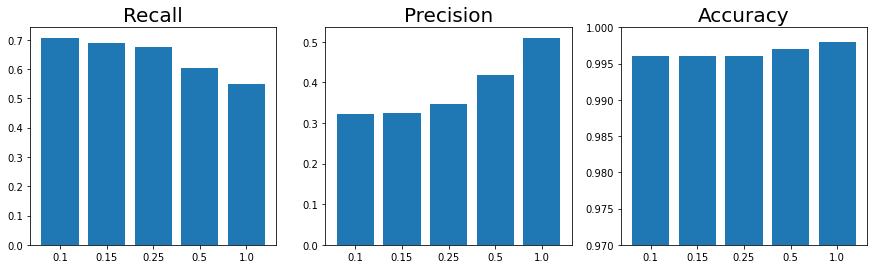

In [24]:
# Plot the different metrics
plt.figure(figsize=(15, 4))
metrics_x = ['0.1', '0.15', '0.25', '0.5', '1.0']

# Recall
plt.subplot(131); plt.title('Recall', fontsize=20)
plt.bar(metrics_x, recall_y)
# Precision
plt.subplot(132); plt.title('Precision', fontsize=20)
plt.bar(metrics_x, precision_y)
# Accuracy
plt.subplot(133); plt.title('Accuracy', fontsize=20)
plt.bar(metrics_x, accuracy_y)
plt.ylim(0.97, 1.0)

plt.show()

## 3.Πρόβλεψη συνδέσμων βάσει similarity-based μετρικών

### 3.1. Suggest correlation method
</B> Προτείνετε μια τουλάχιστον μέθοδο, για να εξερευνήσουμε και να εκφράσουμε μέσα από τα πακέτα NumPy ή SciPy ή Pandas την συσχέτιση (correlation) μεταξύ των τιμών των μετρικών <B>Jaccard Coefficient</B>, <B>Preferential Attachment</B>, <B>Resource Allocation</B> για τον μειωμένο γράφο $G'$. Σημ.: Δεν χρειάζεται κάποια υλοποίηση, μόνο αναφορά της μεθόδου συσχέτισης και επεξήγηση της επιλογής σας.

**ΠΡΟΤΑΣΗ**

---
Αρχικά πρέπει να εξετάσουμε ποιές είναι οι διαθέσιμες επιλογές όσον αφορά την ευρεση **correlation** μεταξύ των 3ων μεθόδων (**Jaccard Coefficient, Preferential Attachment, Resource Allocation**)
[Correlation: numpy, scipy, pandas](https://realpython.com/numpy-scipy-pandas-correlation-python/)
1. Linear correlation (measures linear relationship) 
  - Pearson Correlation
  - Linear Regression
2. Rank Correlation (compares ordering of data)
  - Spearman Correlation
  - Kendall Correlation

Στη δική μας περίπτωση τα δεδομένα που έχουμε δεν αντιπροσωπεύουνται από κάποιο αριθμητικό τύπο αλλά απορρέουν από μία φαινομενικά τυχαία τοπολογία του γράφου. Για αυτό το λόγο δεν μπορούμε από πριν να θεωρήσουμε ότι υπάρχει κάποια γραμμική συσχέτιση των χαρακτηριστικών μεταξύ τους, το οποίο θα μας παρέπεμτε στο Linear Correlation. Υπάρχει όμως η περίπτωση να θέλουμε να εξερευνήσουμε άμα υπάρχει κάποια πιο συγκεκριμένη σχέση μεταξύ των μεθόδων, δηλαδή να προσπαθήσουμε να εξάγουμε κάποιο τύπο. Τότε θα κατατρέξουμε στο Linear Correlation. Στη περίπτωση όμως που χρειαζόμαστε μία πιο γενική εικόνα για το άμα συσχετίζονται και πως οι μέθοδοι αυτοί, τοτε θα χρησιμοποιούσαμε κάποια τεχνική του Rank Correlation, η οποία θα μας έδειχνε για παράδειγμα, άμα όταν αυξάνεται η τιμή της μία παραμέτρου, αυξάνεται και της άλλης.

### 3.2 Add JC, PA, RA to DataFrame
Εργαστείτε πάνω σε <B><U>αντίγραφο</U></B> του dataframe που κατασκευάσατε στο ερώτημα 1.5.1 (unconnected+removables). Δημιουργήστε στήλη (column) με τις ακμές του γράφου και θέστε την ως index του dataframe. Στο dataframe θα προσθέσετε ως στήλες τις τιμές των μετρικών (<B>Jaccard Coefficient</B>, <B>Preferential Attachment</B>, <B>Resource Allocation</B>) για τον μειωμένο γράφο $G'$. Οι τιμές των μετρικών μπορούν να υπολογιστούν με τις συναρτήσεις του πακέτου NetworkX.</li>   </font></html>
    
    |       | link  |Jacc.Coeff.|Pr.Attachment| Resource Allocation|
    |-------|-------|-----------|-------------|--------------------|
    |(1, 6) |  0    |  0.333333 |     32      |    0.700000        |
    |(1, 46)|  0    |  0.200000 |      8      |    0.166667        |

In [25]:
# Create copy of absent edges DataFrame
dbpedia_absent_edges_full_df = dbpedia_absent_edges_df.copy()

# Jaccard Coefficient : https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.jaccard_coefficient.html#networkx.algorithms.link_prediction.jaccard_coefficient
# dbpedia_trunc_JC - list of tuples : [(1, 6, 0.0), (1, 7, 0.3), ...]
dbpedia_trunc_JC_list = [x[2] for x in dbpedia_trunc_JC]

# Preferential Attachment : https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.preferential_attachment.html
dbpedia_trunc_PA = list(nx.preferential_attachment(dbpedia_trunc, dbpedia_absent_edges_pairs))
dbpedia_trunc_PA_list = [x[2] for x in dbpedia_trunc_PA]

# Resource Allocation : https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.resource_allocation_index.html
dbpedia_trunc_RA = list(nx.resource_allocation_index(dbpedia_trunc, dbpedia_absent_edges_pairs))
dbpedia_trunc_RA_list = [x[2] for x in dbpedia_trunc_RA]

# Add additional columns to DataFrame
dbpedia_absent_edges_full_df['Jacc.Coeff.'] = dbpedia_trunc_JC_list
dbpedia_absent_edges_full_df['Pr.Attachment'] = dbpedia_trunc_PA_list
dbpedia_absent_edges_full_df['Rsrc.Allocation'] = dbpedia_trunc_RA_list

# Set edges column as index
dbpedia_absent_edges_full_df = dbpedia_absent_edges_full_df.set_index('edge')

display(dbpedia_absent_edges_full_df)

,link,Jacc.Coeff.,Pr.Attachment,Rsrc.Allocation
edge,,,,
"(1, 6)",0,0.0,7,0.000000
"(1, 46)",0,0.0,1,0.000000
"(1, 47)",0,0.0,1,0.000000
"(1, 48)",0,0.5,2,0.500000
"(1, 32)",0,0.0,6,0.000000
...,...,...,...,...
"(401, 403)",1,1.0,1,0.166667
"(401, 404)",1,1.0,1,0.166667
"(402, 403)",1,1.0,1,0.166667


### 3.3 Random Forest Classifier


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

#### 3.3.1 Model Training
Χρησιμοποιήστε τον Random Forest Classifier και το αντίγραφο dataframe που κατασκευάσατε στο ερώτημα 3.2, για να προβλέψετε συνδέσεις. Συμπληρώστε στον κώδικα: τα features ($X$), την target variable ($y$) και τα ορίσματα της συνάρτησης $fit$ για το training του μοντέλου.</li>


**Split Dataset**

In [27]:
# Split Data (Train Set, Test Set)
dbpedia_model_X = dbpedia_absent_edges_full_df[dbpedia_absent_edges_full_df.columns[1:4]]  # features
dbpedia_model_Y = dbpedia_absent_edges_full_df['link']                                     # target

x_train, x_test, y_train, y_test = train_test_split(dbpedia_model_X, dbpedia_model_Y, test_size=0.33, random_state = 0)

In [28]:
dbpedia_metrics = [
    ("Train Set (data)", len(x_train.index)),
    ("Test Set (data)", len(x_test.index)),
]
print(table_view(dbpedia_metrics))

+------------------+-------+
| Train Set (data) | 61573 |
+------------------+-------+
| Test Set (data)  | 30327 |
+------------------+-------+


**Train Model (Random Forest Classifier)**

In [29]:
# RandomForestClassifier : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
RF_classifier = RandomForestClassifier()
MM_scaler = MinMaxScaler() # For data normalization

# Normalize features
x_train_scaled = MM_scaler.fit_transform(x_train)
x_test_scaled = MM_scaler.transform(x_test)

# Parameters
dbpedia_model_parameters = {
    'n_estimators' : [10,50,100], # Number of trees in the forest
    'max_depth' : [5,10,15]       # Max depth of the tree
} 
dbpedia_model = GridSearchCV(RF_classifier, param_grid = dbpedia_model_parameters) 

In [30]:
# Train Model
dbpedia_model.fit(x_train_scaled, y_train)
# Make predictions
dbpedia_predictions = dbpedia_model.predict(x_test_scaled)  

#### 3.3.2 Top results
Δώστε τις ($A.M$ $mod$ $10$) πρώτες προβλέψεις και την ακρίβεια ($accuracy$) του μοντέλου. </li>

In [31]:
dbpedia_metrics = [
    # Get first 3 predictions (should be 0)
    ("First 3 predictions", list(dbpedia_predictions[:AM])),
    # Get model accuracy
    ("Model accuracy", accuracy_score(y_test, dbpedia_predictions)),
]
print(table_view(dbpedia_metrics))

+---------------------+-------------------+
| First 3 predictions | [0, 0, 0]         |
+---------------------+-------------------+
| Model accuracy      | 0.998911860718172 |
+---------------------+-------------------+


#### 3.3.3 Calculate link prediction for (1, 47)
Υπολογίστε την πιθανότητα να συνδεθούν οι κόμβοι ($1$,$47$) βάσει του μοντέλου σας. </li>  

In [32]:
# Get the edge (1, 47) - DataFrame of features
dbpedia_mode_X_1_47 = MM_scaler.transform(dbpedia_model_X.loc[[(1, 47)]])
# Predict its probabilities - List of float (one probabiliy for each class)
dbpedia_mode_X_1_47_prob = dbpedia_model.predict_proba(dbpedia_mode_X_1_47)
# Get the probability for class 1 (link exists)
dbpedia_metrics = [
    ("Probability for (1 - 47) link", dbpedia_mode_X_1_47_prob[0][1]),
]
print(table_view(dbpedia_metrics))

+-------------------------------+-------------+
| Probability for (1 - 47) link | 0.000343134 |
+-------------------------------+-------------+


## 4.Πρόβλεψη συνδέσμων με embedding βασισμένο σε τυχαίους περιπάτους (Random Walks)

### 4.1 Feature extraction
Εξάγετε τα χαρακτηριστικά (features) του γράφου $G'$, που προέκυψε από την αφαίρεση των ακμών. Για τον σκοπό αυτό χρησιμοποιήστε τον αλγόριθμο <B>Node2vec</B> <a href="https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf">[3]</a>. Ο αλγόριθμος αντιστοιχίζει τους κόμβους του γράφου μέσω τυχαίων περιπάτων (biased 2nd order random walks) σε ένα χώρο μικρού αριθμού διαστάσεων (low dimensional space) διατηρώντας την μεταξύ τους γειτνίαση.
<BR>Για την επιλογή των παραμέτρων: 
<li>p - παράμετρος τυχαίων περιπάτων p που καθορίζει την πιθανότητα “1/p” επιστροφής στον κόμβο προέλευσης (source node), </li>
<li>q - παράμετρος τυχαίων περιπάτων q που καθορίζει την πιθανότητα  “1/q” μετακίνησης σε κόμβο μακριά από τον κόμβο προέλευσης (source node), </li>
<li>dimensions - πλήθος διαστάσεων των Node2Vec embeddings, </li>
<li>num_walks - αριθμός περιπάτων από κάθε κόμβο, </li>
<li>walk_length - μήκος τυχαίου περιπάτου, </li>
<li>window_size - μέγεθος παραθύρου context για τον αλγόριθμο Word2Vec, </li>
<li>num_iter - αριθμός SGD επαναλήψεων (epochs), </li>
<li>workers - αριθμός workers για τον Word2Vec,</li>
            χρησιμοποιήστε τις τιμές:   </html>
   
                   

 |   p   |   q   | dimensions|  num_walks  |walk_length |window_size|        workers            |
 |-------|-------|-----------|-------------|------------|-----------|---------------------------|
 |  1.0  |  1.0  |  128      |     10      |    80      |     10    |multiprocessing.cpu_count()|

In [36]:
from node2vec import Node2Vec  
import multiprocessing         

#generate walks
node2vec_walker = Node2Vec(
    dbpedia_trunc, 
    p = 1.0, 
    q = 1.0, 
    dimensions = 128, 
    num_walks = 10, 
    walk_length = 80,
    workers = multiprocessing.cpu_count()
)

#train node2vec model
node2vec_model = node2vec_walker.fit(window = 10 , min_count = 1)

Computing transition probabilities:   0%|          | 0/430 [00:00<?, ?it/s]

### 4.2 Apply Random Forest
Εφαρμόστε τον αλγόριθμο Random Forest Classifier, για να προβλέψετε τις συνδέσεις.

In [50]:
#apply trained Node2Vec model on each node pair of the dataframe "unconnected + removables"
# Unconnected + Removable edges : dbpedia_absent_edges_pairs - list of pairs [(1, 2), (1, 3), ...]
dbpedia_node2vec_X = [(node2vec_model.wv[str(i)] + node2vec_model.wv[str(j)]) for i, j in dbpedia_absent_edges_pairs]   # features
dbpedia_node2vec_Y = list(dbpedia_absent_edges_full_df['link'])                                                         # target

In [56]:
# Split Data (Train Set, Test Set)
x_train, x_test, y_train, y_test = train_test_split(dbpedia_node2vec_X, dbpedia_node2vec_Y, test_size=0.33, random_state = 0)

In [57]:
RF_classifier = RandomForestClassifier(
    max_depth=2, 
    random_state=0
) 

# Train the model
RF_classifier.fit(x_train, y_train)   
# Make predictions
dbpedia_node2vec_predictions = RF_classifier.predict(x_test) 

### 4.3 Calculate Accuracy
Υπολογίστε την ακρίβεια ($accuracy$) του μοντέλου. </li><BR></font></html>

In [59]:
dbpedia_metrics = [
    # Get model accuracy
    ("Model accuracy", accuracy_score(y_test, dbpedia_node2vec_predictions)),
]
print(table_view(dbpedia_metrics))

+----------------+----------+
| Model accuracy | 0.998648 |
+----------------+----------+


### Ερώτηση bonus (+10/100):
Για τους binary operators για learning των edge features με τον αλγόριθμο Node2Vec που αναφέρονται στο <a href="https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf">[3]</a> ((α) Average, (β) Hadamard, (γ) Weighted-L1 και (δ) Weighted-L2) τροποποιήστε τoν κώδικά σας και σημειώστε τις παρατηρήσεις σας ως προς την απόδοση του αλγορίθμου.</font></html>

<html><font size=4><B><U>Βιβλιογραφία:</U></B><BR></font>
<a href="https://dl.acm.org/doi/10.1145/2487788.2488173">[1]	Jérôme Kunegis. KONECT – The Koblenz Network Collection. In Proc. Int. Conf. on World Wide Web Companion, pages 1343–1350, 2013.</a><BR>
<a href="https://link.springer.com/chapter/10.1007/978-3-540-76298-0_52">[2]	Sören Auer, Christian Bizer, Georgi Kobilarov, Jens Lehmann, Richard Cyganiak, and Zachary Ives. DBpedia: A nucleus for a web of open data. In Proc. Int. Semant. Web Conf., pages 722–735, 2008.<BR>
<a href="https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf">[3] A. Grover, J. Leskovec, Node2vec: Scalable Feature Learning for Networks. ACM KDD, 2016.</a><BR>
 <a href="https://proceedings.neurips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf">[4] T.Mikolov, I.Sutskever, K.Chen, G.S.Corrado and J.Dean, Distributed representations of words and phrases and their compositionality. In NIPS, 2013.</a><BR></font></html>

In [60]:
from node2vec.edges import (
    AverageEmbedder,
    HadamardEmbedder,
    WeightedL1Embedder,
    WeightedL2Embedder,
)

In [61]:
def model_accuracy(embedder):
  # Create the binary operator
  binary_operator = embedder(keyed_vectors=node2vec_model.wv)
  # Create the vector embeddings (with the operator)
  dbpedia_node2vec_X = [binary_operator[(str(i), str(j))] for i, j in dbpedia_absent_edges_pairs]   # features
  dbpedia_node2vec_Y = list(dbpedia_absent_edges_full_df['link'])                                   # target

  # Split Data (Train Set, Test Set)
  x_train, x_test, y_train, y_test = train_test_split(dbpedia_node2vec_X, dbpedia_node2vec_Y, test_size=0.33, random_state = 0)  
  # Create a RF classifier instance
  RF_classifier = RandomForestClassifier(
    max_depth=2, 
    random_state=0
  ) 

  # Train the model
  RF_classifier.fit(x_train, y_train)   
  # Make predictions
  dbpedia_node2vec_predictions = RF_classifier.predict(x_test) 

  return accuracy_score(y_test, dbpedia_node2vec_predictions)

In [63]:
dbpedia_metrics = [
    ("Average", model_accuracy(AverageEmbedder)),
    ("Hadamard", model_accuracy(HadamardEmbedder)),
    ("Weighted-L1", model_accuracy(WeightedL1Embedder)),
    ("Weighted-L2", model_accuracy(WeightedL2Embedder)),
]
print(table_view(dbpedia_metrics))

+-------------+----------+
| Average     | 0.998648 |
+-------------+----------+
| Hadamard    | 0.998318 |
+-------------+----------+
| Weighted-L1 | 0.997395 |
+-------------+----------+
| Weighted-L2 | 0.997395 |
+-------------+----------+


**Παρατηρήσεις**

---
Από τους 4 binary operators παρατηρούμε ότι αυτός με το μεγαλύτερο accuracy score είναι o Average ο οποίος όμως δεν ξεπερνά το accuracy της απλής υλοποίησης του node2vec στην οποία απλά προσθέτουμε τα embeddings των 2 άκρων του διανύσματος.